In [2]:
using CairoMakie
using DelimitedFiles, Statistics, Glob, LaTeXStrings, StatsBase, LinearAlgebra, SparseArrays, Distances, LazySets;
using Measures: mm

include("final_analysis_library.jl");

In [3]:
#simulation params
L = 8
N = 128
M = 100
B = 1;
nu = 0.005;
Delta = 4.;
F0 = 1.; 

K = 4
pk = 0.2

folder = "../data/Delta$(Delta)_F0$(F0)_nu$(nu)_N$(N)_M$(M)_B$(B)_L$(L)/half_fixed/long_K$(K)_pk$(pk)/";

sfolder = folder*"zeros/sample_1/"
fieldmatrix = readdlm(sfolder*"fieldmatrix.txt",header=true)[1][:,2:end];


means = mean(fieldmatrix,dims=1)
dh = fieldmatrix .- means
cij = (dh' * dh)/M
F,V,G = get_FVG(means,cij,L,K)

ncopies = 100
tini = 75
nsteps = 200
dt = 50;

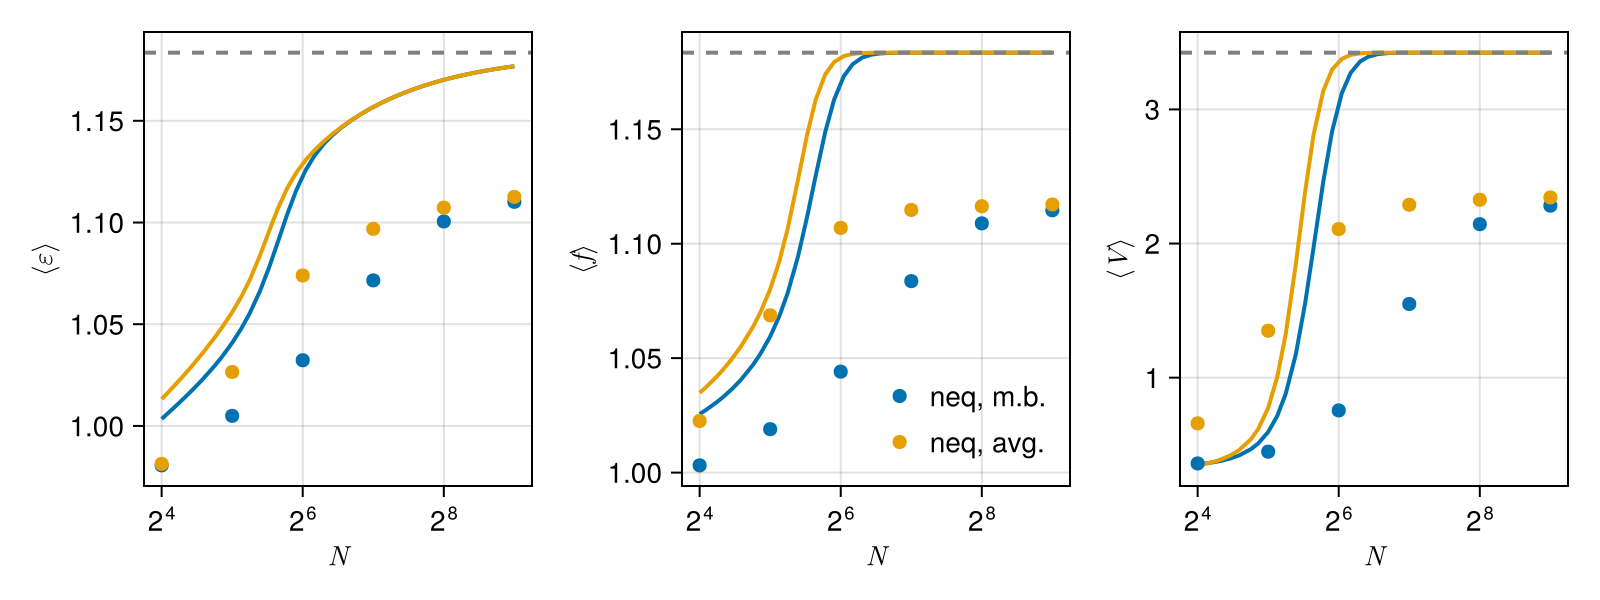

In [4]:
#equilibrium data
f0 = mean(F)
V0 = mean(V)

F = F./f0
V = V./f0.^2
V0 = V0/f0^2

Narr = floor.(2 .^range(4.,9.,length=40))
energies = []
ref_energies = []
fits = []
ref_fits = []
variances = []
ref_variances = []
gens = []
for N in Narr
    en = F.-(V./N)
    beta = 2*(N-1)/(1+V0)
    beta0 = 2*(N-1)
    boltz = exp.(beta.*(en.-maximum(en)))
    boltz = boltz./sum(boltz)
    boltz0 = exp.(beta0.*(en.-maximum(en)))
    boltz0 = boltz0./sum(boltz0)
    push!(energies, sum(boltz.*en))
    push!(fits, sum(boltz.*F))
    push!(variances, sum(boltz.*V))
    push!(ref_energies, sum(boltz0.*en))
    push!(ref_fits, sum(boltz0.*F))
    push!(ref_variances, sum(boltz0.*V))
end


f = Figure(size=(800, 300))
ax = [Axis(f[1, k], xlabel=L"N",xscale=log2) for k in 1:3]
ax[1].ylabel=L"\langle\varepsilon\rangle"
ax[2].ylabel=L"\langle f \rangle"
ax[3].ylabel=L"\langle V \rangle"

lines!(ax[1], Narr, energies,linewidth=2)
lines!(ax[1], Narr, ref_energies,linewidth=2)
hlines!(ax[1], maximum(F), color=:gray, linewidth=2,linestyle=:dash)
lines!(ax[2], Narr, fits,linewidth=2)
lines!(ax[2], Narr, ref_fits,linewidth=2)
hlines!(ax[2], maximum(F), color=:gray, linewidth=2,linestyle=:dash)
lines!(ax[3], Narr, variances,linewidth=2,label = "eq, m.b.")
lines!(ax[3], Narr, ref_variances,linewidth=2,label = "eq, avg.")
hlines!(ax[3], maximum(V), color=:gray, linewidth=2,linestyle=:dash)



#non equilibrium data
Narr = 2 .^range(4,9)

pref = "../data/persistent/Delta$(Delta)_F0$(F0)_nu$(nu)_"
postf = "_M100_B1_L$(L)_pers0.0/half_fixed/long_K$(K)_pk$(pk)/"
lN = length(Narr);

F,V,G = get_FVG(means,cij,L,K)


Favg = zeros(lN)
Favg_ref = zeros(lN)
Vavg = zeros(lN)
Vavg_ref = zeros(lN)

j=1
inits = ["zeros/","ones/","rand1/","rand2/","rand3/","rand4/","rand5/"]
for N in Narr
    folder = pref*"N$(N)"*postf
    _,popV = prf(folder,"saved_snaps",tini,nsteps,ncopies,dt,V);
    _,popV_ref = prf(folder,"saved_snaps_ref",tini,nsteps,ncopies,dt,V);
    for init_cond in inits
        favg,gavg,fref,gref,fdist,gdist,fr_dist,gr_dist = get_means_distr(folder*init_cond, ncopies, tini)
        Favg[j] += favg
        Favg_ref[j] += fref
    end
    Vavg[j] = mean(popV)
    Vavg_ref[j] = mean(popV_ref)
    j+=1
end
den = Narr*length(inits)
Favg ./= den
Favg_ref ./= den

scatter!(ax[2],Narr,Favg,markersize=10,label="neq, m.b.")
scatter!(ax[2],Narr,Favg_ref,markersize=10,label="neq, avg.")

scatter!(ax[3],Narr,Vavg,markersize=10,label="neq, m.b.")
scatter!(ax[3],Narr,Vavg_ref,markersize=10,label="neq, avg.")

scatter!(ax[1],Narr,Favg.-Vavg./Narr,markersize=10,label="neq, m.b.")
scatter!(ax[1],Narr,Favg_ref.-Vavg_ref./Narr,markersize=10,label="neq, avg.")

axislegend(ax[2],position=:rb,framevisible = false)

save("../data/plots/SI_eq_vs_neq.pdf",f)

f   


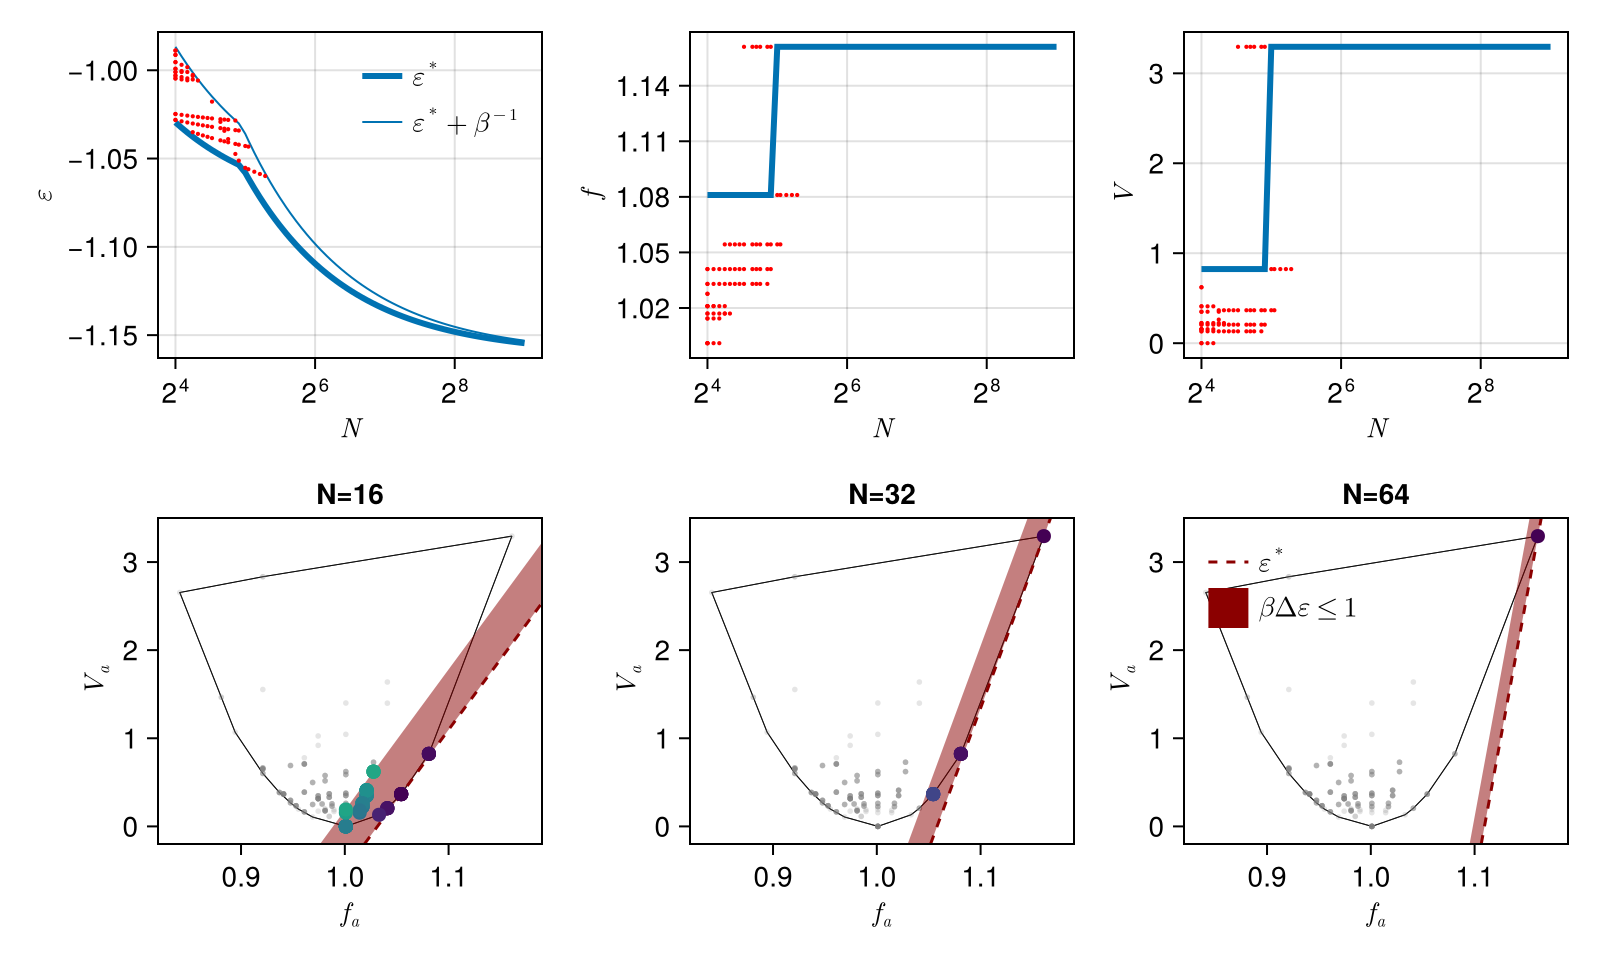

In [8]:
f = Figure(size=(800, 480))
pgraph = [Axis(f[2,i],xgridvisible = false,ygridvisible = false, limits=((0.82,1.19),(-0.2,3.5))) for i in 1:3]
sfolder = folder*"zeros/sample_1/"
fieldmatrix = readdlm(sfolder*"fieldmatrix.txt",header=true)[1][:,2:end]


for spec in 0:2^L-1
    seq = digits(spec,base=2,pad=L)
    onehot = Matrix(I, L, L)
    neighs = [(seq .+ onehot[:,k]).%2 for k in 1:L]
    ngh = [bin_to_int(neighs[k]) for k in 1:L]
end
t = map(F, V) do xi, yi
           [xi, yi]
    end;
ch = convex_hull(t)
C = reduce(hcat,ch)

for i in 1:3
    lines!(pgraph[i],push!(C[1,:],C[1,1]),push!(C[2,:],C[2,1]),color=:black,alpha=0.8,linewidth=0.5)
    lines!(pgraph[i],push!(C[1,:],C[1,1]),push!(C[2,:],C[2,1]),color=:black,alpha=0.8,linewidth=0.5)
end

[scatter!(pgraph[i],F,V,alpha=0.2,markersize=4,color=:gray) for i in 1:3]

for i in 1:3
    pgraph[i].xlabel = L"f_a"
    pgraph[i].ylabel = L"V_a"
end

fmin = 0.8
fmax = 1.2

##1 
N = 2^4
id = sortperm(F.-V./N)[end]
estar = F[id] - V[id]/N
beta = 2*(N+1)/(1+V0)
emin = estar-1/beta   
lines!(pgraph[1],[fmin,fmax],[N*(fmin-estar),N*(fmax-estar)],color=:darkred,linestyle=:dash)
fill_between!(pgraph[1],[fmin,fmax],[N*(fmin-estar),N*(fmax-estar)], [N*(fmin-emin),N*(fmax-emin)],color=:darkred,alpha=0.5)

##2-3 
id = argmax(V)
fext = [1.06,1.11]
for k in 2:3
    N = 2^(3+k)
    estar = F[id] - V[id]/N
    beta = 2*(N+1)/(1+V0)
    emin = estar-1/beta
    lines!(pgraph[k],[fmin,fmax],[N*(fmin-estar),N*(fmax-estar)],color=:darkred,linestyle=:dash,label=L"\varepsilon^*")
    fill_between!(pgraph[k],[fmin,fmax],[N*(fmin-estar),N*(fmax-estar)], [N*(fmin-emin),N*(fmax-emin)],color=:darkred,alpha=0.5,
    label=L"\beta\Delta\varepsilon\leq 1")
end

k = 1
for N in 2 .^range(4,6)
    en = F.-(V./N)
    beta = 2*(N+1)/(1+V0)
    maximum_en = maximum(en)
    idx = copy(findall(x->x >= maximum_en - 1/beta, en) )
    scatter!(pgraph[k],F[idx],V[idx],markersize=10, color=en[idx], colormap=cgrad(:viridis,rev=true), colorrange = (maximum(en)*0.93, maximum(en)))
    pgraph[k].title = "N=$(N)" 
    k+=1
end

axislegend(pgraph[3],position=:lt,framevisible = false)

axb = [Axis(f[1,k], xscale=log2, xlabel=L"N") for k in 1:3]
Narr = floor.(2 .^range(4.,9.,length=70))
de = range(0,1,21)
for i in 2:length(de) 
    energy = []
    Ncoord = []
    fitness = []
    variance = []
    for N in Narr
        en = F.-(V./N)
        beta = 2*(N+1)/(1+V0)
        maximum_en = maximum(en)
        idx_arr = findall(x-> maximum_en - de[i-1]/beta>= x > maximum_en - de[i]/beta, en) 
        if length(idx_arr)>0
            idx = idx_arr[1]
            push!(Ncoord, N)
            push!(energy,-en[idx])
            push!(fitness,F[idx])
            push!(variance,V[idx])
        end
    end
    if length(Ncoord)==length(Narr)
        lines!(axb[1],Ncoord,energy,linewidth=3,label=L"\varepsilon^*")
        lines!(axb[2],Ncoord,fitness,linewidth=3)
        lines!(axb[3],Ncoord,variance,linewidth=3)
        lines!(axb[1],Ncoord,energy.+(1+V0).*0.5./(Narr.+1),linewidth=1,color=Makie.wong_colors()[1],label=L"\varepsilon^*+\beta^{-1}")
    else
        scatter!(axb[1],Ncoord,energy,markersize=3,color=:red)
        scatter!(axb[2],Ncoord,fitness,markersize=3,color=:red)
        scatter!(axb[3],Ncoord,variance,markersize=3,color=:red)
    end
end

axb[1].ylabel= L"\varepsilon"
axb[2].ylabel= L"f"
axb[3].ylabel= L"V"

axislegend(axb[1],position=:rt,framevisible = false)

save("../data/plots/SI_equilibrium_pop.pdf",f)

f